#### SVM实现--简易版

测试数据如下：

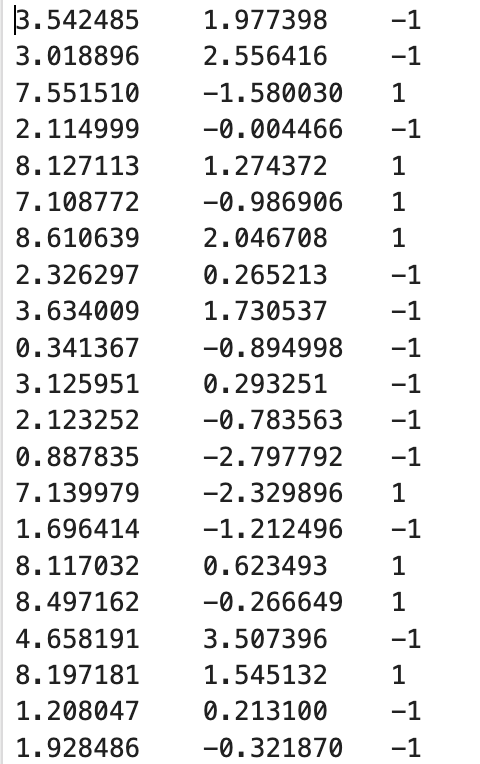

In [1]:
# （1）加载数据
def loaddata(fileName):
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]),float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat, labelMat

In [12]:
dataMat,labelMat = loaddata('./data/svm1.txt')
print(type(dataMat))

<class 'list'>


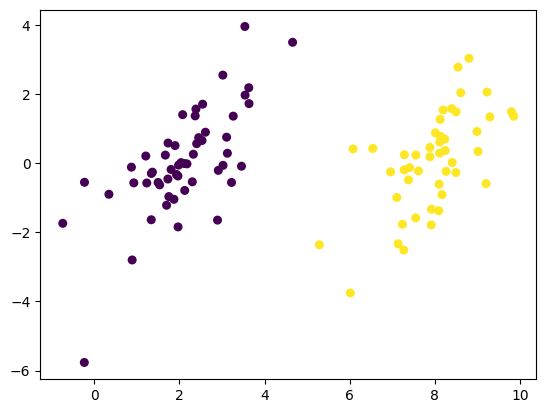

array([-1., -1.,  1., -1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1.,
        1., -1.,  1.,  1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1.,
        1., -1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,
        1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
       -1., -1.,  1.,  1., -1.,  1., -1., -1., -1., -1.,  1., -1.,  1.,
       -1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1., -1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,  1., -1.,  1.,
        1.,  1., -1., -1., -1., -1., -1., -1., -1.])

In [15]:
# （2）画散点图
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(array(dataMat)[:,0],array(dataMat)[:,1],c=array(labelMat).squeeze(),s=30) # 按标签的不同来分类
plt.show()
array(labelMat).squeeze()

In [4]:
# 在选定某一个alpha_i后，随机选择另一个alpha_j
def selectJrand(i,m): # m代表约束的个数，即alpha的个数
    j = i
    while(j==i):
        j = int(random.uniform(0,m))
    return j

##### SMO算法核心

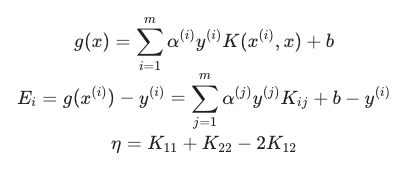

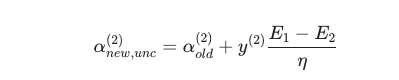

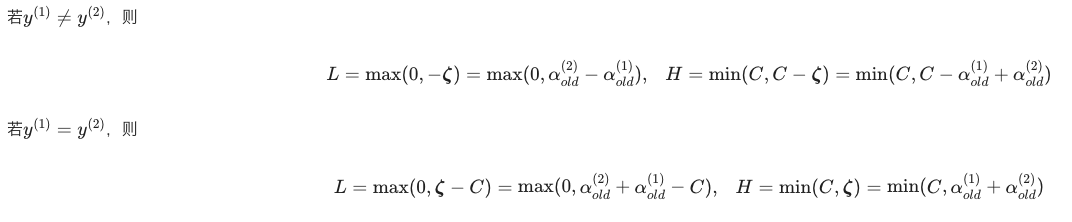

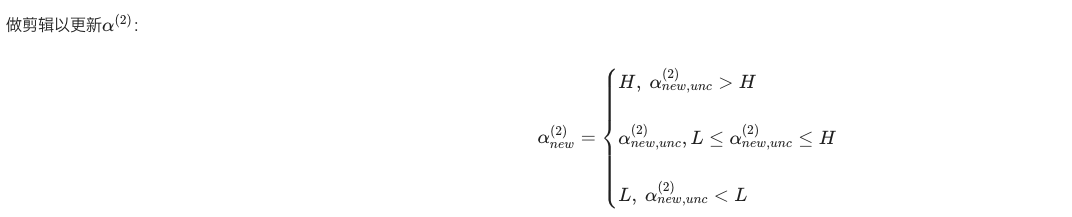

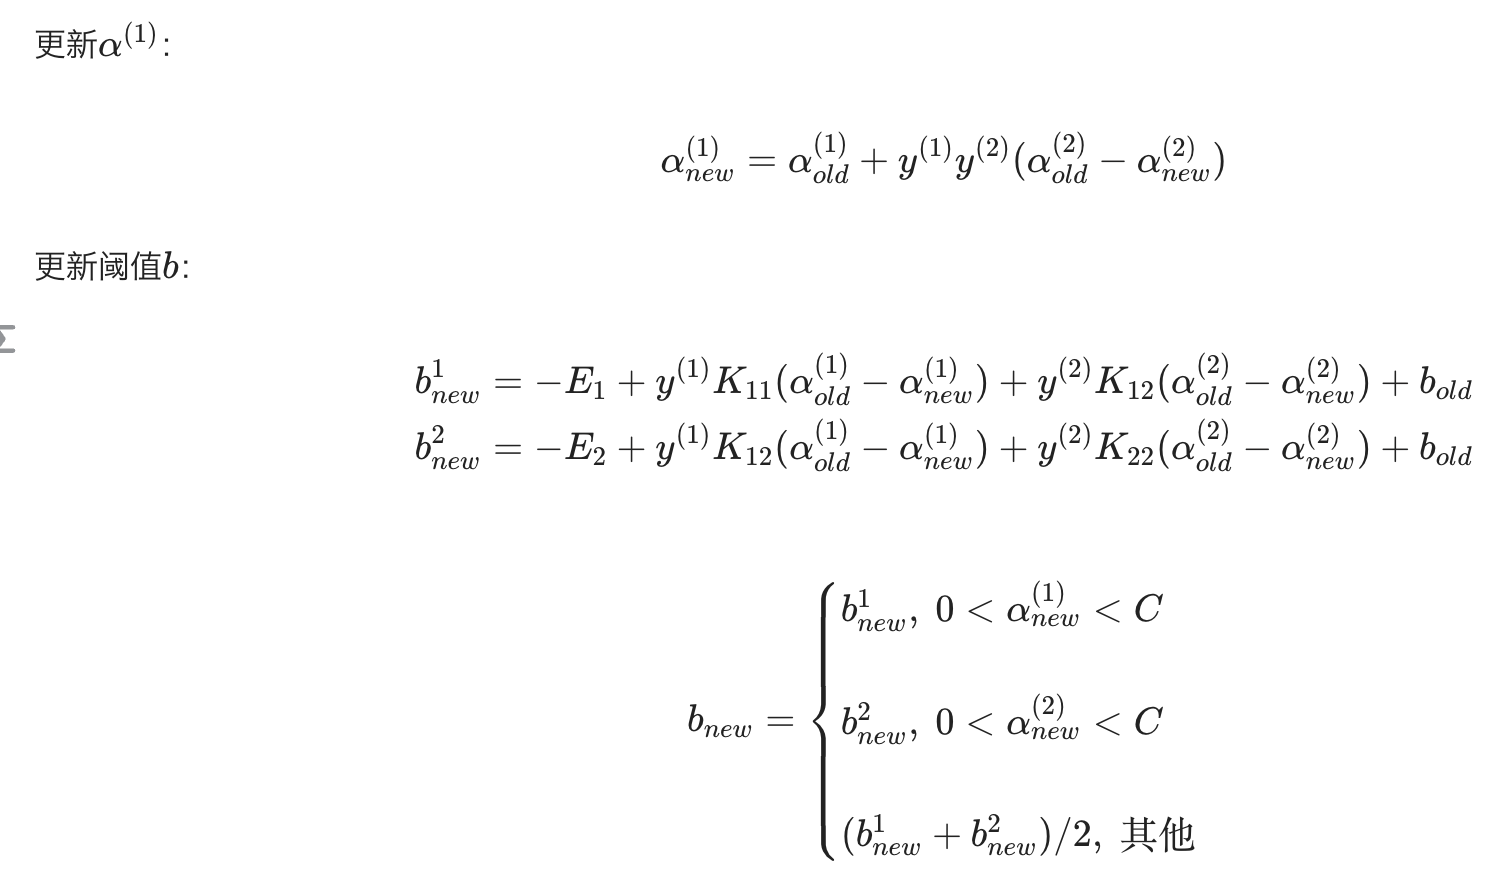

In [5]:
# （3）剪辑
def clipAlpha(aj,H,L):
    if aj > H:
        return H
    elif aj >= L:
        return aj
    else:
        return L

In [6]:
def smoSimple(dataMathIn, classLabels, C, toler, maxIter): #利用SMO算法计算alpha和b
    dataMatrix = matrix(dataMathIn); labelMat = matrix(classLabels).transpose()
    # 初始化b为0
    b = 0
    # 获取数据维度
    m,n = dataMatrix.shape
    # 初始化所有alpha为0
    alphas = matrix(zeros((m,1)))
    
    # 迭代求解
    iter = 0
    while (iter<maxIter):
        alphaPairsChanged = 0 # 记录一次迭代中，更新的次数
        for i in range(m): # 选择SMO算法中的第一个样本alphai
            # 计算g(xi)
            gXi = float(multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[i,:].T))+b
            # 计算Ei
            Ei = gXi - float(labelMat[i])
            # 如果样本不满足KKT条件，随机选择另一个alpha进行优化
            
            # 约束 1-g(xi)*yi-xita <=0 对应的KKT条件为 alphas[i] * (1-g(xi)*yi-xita[i])=0
            # 约束 -xita[i] <=0 对应的KKT条件为 mu[i] * (-xita[i])=0
            # C = mu[i] + alphas[i]
            # 当 labelMat[i]*Ei<0，即 g(xi)*yi - 1 <0时，1-g(xi)*yi>0，xita >= 1-g(xi)*yi > 0，样本点落在可行域中，约束 -xita[i] <=0 不起作用，因此mu[i]=0，alphas[i]=C
            # 当 labelMat[i]*Ei>0，即 g(xi)*yi - 1 >0时，1-g(xi)*yi<0，，约束1-g(xi)*yi-xita[i] <=0 不起作用，因此alphas[i]=0
            if((labelMat[i]*Ei < -toler) and (alphas[i]<C)) or ((labelMat[i]*Ei>toler) and (alphas[i]>0)):
                # 随机选择一个待优化的alphaj
                j = selectJrand(i,m)
                # 计算g(xj)
                gXj = float(multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[j,:].T))+b
                # 计算Ej
                Ej = gXj - float(labelMat[j])

                # 复制原来的alphas，用作old值
                alphaIold = alphas[i,0].copy()
                alphaJold = alphas[j,0].copy()
                
                # 计算eta
                eta = 2.0*dataMatrix[i,:]*dataMatrix[j,:].T - dataMatrix[i,:]*dataMatrix[i,:].T - dataMatrix[j,:]*dataMatrix[j,:].T
                if eta >= 0: print("eta>=0"); continue # 理论上来说，eta始终小于0

                 # 计算上下界，并剪辑alpha[j]
                if (labelMat[i] != labelMat[j]):
                    L = max([0,alphaJold-alphaIold])
                    H = min([C,C-alphaIold+alphaJold])
                else:
                    L = max([0,alphaJold+alphaIold-C])
                    H = min([C,alphaIold+alphaJold])

                if L==H: print("L==H"); continue 
                # 计算alphaj
                alphas[j] -= labelMat[j]*(Ei-Ej)/eta
                alphas[j] = clipAlpha(alphas[j],H,L)
                if (abs(alphas[j] - alphaJold) < 0.00001): print("j not moving enough"); continue
                # 计算alpha i 
                alphas[i] += labelMat[i]*labelMat[j]*(alphaJold - alphas[j])
                # 计算b1
                b1 = -Ei + labelMat[i]*dataMatrix[i,:]*dataMatrix[i,:].T * (alphaIold - alphas[i]) + labelMat[j]*dataMatrix[i,:]*dataMatrix[j,:].T * (alphaJold - alphas[j]) +  b
                # 计算b2
                b2 = -Ej + labelMat[i]*dataMatrix[i,:]*dataMatrix[j,:].T * (alphaIold - alphas[i]) + labelMat[j]*dataMatrix[j,:]*dataMatrix[j,:].T * (alphaJold - alphas[j]) +  b
                # 决定b
                if (alphas[i]>0) and (alphas[i]<C): 
                    b = b1
                elif (alphas[j]>0) and (alphas[j]<C):
                    b = b2
                else:
                    b = (b1+b2)/2.0
                alphaPairsChanged += 1
                print("iter: %d i: %d, pairs changed %d" % (iter, i, alphaPairsChanged))
                
        if(alphaPairsChanged==0): # 此次循环中，没有任何一对alpha被更新
            iter += 1
        else: # 此次迭代中，有至少一对alpha被更新，则迭代次数重置
            iter = 0
        print("iteration number %d" % iter)
    return b, alphas

#### 计算W

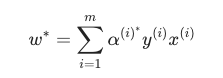

In [7]:
def calWs(alphas, dataArr, classLabels):
    X = matrix(dataArr); labelMat = matrix(classLabels).transpose()
    m,n = shape(X)
    w = zeros((n,1))
    for i in range(m):
        w += multiply(alphas[i]*labelMat[i],X[i,:].T)
    return w

In [8]:
# 调用上述方法，求解w,b，alpha
dataMat,labelMat = loaddata('./data/svm1.txt')

b,alphas = smoSimple(dataMat,labelMat,0.6,0.001,40)
w = calWs(alphas,dataMat,labelMat)

print("b = ", b)
print("alphas = ", alphas)
print("w=",w)

/tmp/ipykernel_29742/3000730142.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gXi = float(multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[i,:].T))+b
/tmp/ipykernel_29742/3000730142.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ei = gXi - float(labelMat[i])
/tmp/ipykernel_29742/3000730142.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gXj = float(multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[j,:].T))+b
/tmp/ipykernel_29742/3000730142.py:3

iter: 0 i: 0, pairs changed 1
L==H
j not moving enough
j not moving enough
j not moving enough
iter: 0 i: 17, pairs changed 2
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
L==H
L==H
L==H
L==H
j not moving enough
L==H
iter: 0 i: 54, pairs changed 3
L==H
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
iteration number 0
j not moving enough
L==H
L==H
iter: 0 i: 4, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
L==H
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
iter: 0 i: 54, pairs changed 2
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
iteration number 0
j not moving enough
j not moving enough
j not moving enough

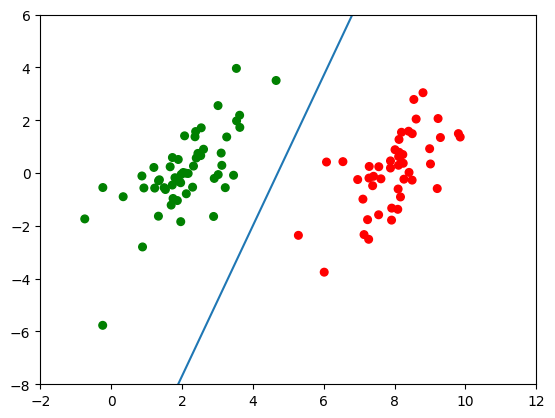

In [9]:
# 绘制决策平面 w*x + b = 0，即 w_0 x_0 + w_1 x_1 + b = 0
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Circle

fig = plt.figure()
ax = fig.add_subplot(111)
cm_dark = mpl.colors.ListedColormap(['g','r'])
ax.scatter(array(dataMat)[:,0],array(dataMat)[:,1],c=array(labelMat).squeeze(),cmap=cm_dark,s=30)

x = arange(-2.0,12.0,0.1)
y = (-w[0]*x - b) / w[1]
ax.plot(x,y.reshape(-1,1))
ax.axis([-2,12,-8,6])
plt.show()

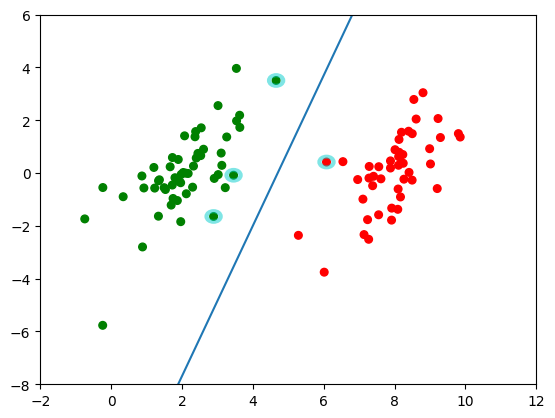

In [10]:
# 画支持向量
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Circle

fig = plt.figure()
ax = fig.add_subplot(111)
cm_dark = mpl.colors.ListedColormap(['g','r'])
ax.scatter(array(dataMat)[:,0],array(dataMat)[:,1],c=array(labelMat).squeeze(),cmap=cm_dark,s=30)

x = arange(-2.0,12.0,0.1)
y = (-w[0]*x - b) / w[1]
ax.plot(x,y.reshape(-1,1))
ax.axis([-2,12,-8,6])

alphas_non_zeros_index = where(alphas>0)
for i in alphas_non_zeros_index[0]:
    circle = Circle((dataMat[i][0],dataMat[i][1]),0.2,facecolor='none',edgecolor=(0,0.8,0.8),linewidth=3,alpha=0.5)
    ax.add_patch(circle)
plt.show()

In [17]:
print(alphas.T)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.15277173
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.16570883
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.05024049 0.
  0.         0.36872104 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         